## 0858610 周承翰 Handcraft CNN

### 練習
手工設計一個 CNN 網路，能夠模擬 Conway's Game of Life 的規則。 也就是說，將輸入一個盤面，輸出下一步的盤面狀態。

可以用多層或者一層 Hidden Layer 。

<img src="https://upload.wikimedia.org/wikipedia/commons/e/e5/Gospers_glider_gun.gif" />
https://en.wikipedia.org/wiki/Conway%27s_Game_of_Life

(from 中文維基百科)

生命遊戲中，對於任意細胞，規則如下：
每個細胞有兩種狀態-存活或死亡，每個細胞與以自身為中心的周圍八格細胞產生互動。（如圖，黑色為存活，白色為死亡）

    當前細胞為存活狀態時，當周圍低於2個（不包含2個）存活細胞時， 該細胞變成死亡狀態。（模擬生命數量稀少）
    當前細胞為存活狀態時，當周圍有2個或3個存活細胞時， 該細胞保持原樣。
    當前細胞為存活狀態時，當周圍有 超過 3個存活細胞時，該細胞變成死亡狀態。（模擬生命數量過多）
    當前細胞為死亡狀態時，當周圍有3個存活細胞時，該細胞變成存活狀態。 （模擬繁殖）

可以把最初的細胞結構定義為種子，當所有在種子中的細胞同時被以上規則處理後, 可以得到第一代細胞圖。按規則繼續處理當前的細胞圖，可以得到下一代的細胞圖，周而復始。

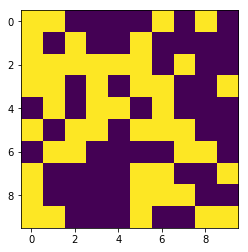

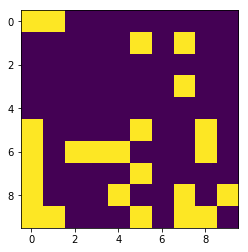

In [0]:
# 參考：用來生成 Game of Life 的下一個狀態，用來檢查
# 用比較笨的方式，厲害一點用 http://stackoverflow.com/questions/32660953/numpy-sliding-2d-window-calculations

import numpy as np

#使用game function -> 輸入一個盤面board
#經由function return下一個盤面
def game(board):
    #np.pad將原本的borad從NxN擴展為N+1xN+1 -> 以0做padding
    board_pad = np.pad(board, 1, 'constant', constant_values = 0)
    #做一個與board一樣大小NxN的zero Martix
    rtn = np.zeros_like(board)
    #依據borad的情況計算出下一個盤面並存在rtn
    for i in range(board.shape[0]):
        for j in range(board.shape[1]):
            alive = board[i, j]
            neighbord_count = board_pad[i:i+3, j:j+3].sum() - alive
            if (alive and neighbord_count == 2) or neighbord_count==3:
                rtn[i,j] = 1
    return rtn
  
  
# 隨機生成一個盤面
board = np.random.randint(0,2, size=(10,10))
# 畫出來看看
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(0)
plt.imshow(board)

# 跑出下一個盤面
board_after = game(board)
# 畫出來看看
plt.figure(1)
plt.imshow(board_after);

In [0]:
rtn = np.ones(shape=(3,3,1,4), dtype='float32')
rtn

array([[[[1., 1., 1., 1.]],

        [[1., 1., 1., 1.]],

        [[1., 1., 1., 1.]]],


       [[[1., 1., 1., 1.]],

        [[1., 1., 1., 1.]],

        [[1., 1., 1., 1.]]],


       [[[1., 1., 1., 1.]],

        [[1., 1., 1., 1.]],

        [[1., 1., 1., 1.]]]], dtype=float32)

In [0]:
# 下面來定義 CNN 網路
import keras 

# 權重
def W(size, dtype='float32'):
    #rtn = 3x3個(9個)1x4的array (value皆為1)
    rtn = np.ones(shape=(3,3,1,4), dtype=dtype)
    # rtn[1][1][0][2] = 10 && rtn[1][1][0][3] = 10 
    rtn[1,1,0,2:] = 10
    return rtn

def b(size, dtype='float32'):    
    return np.array([-2,-3, -12,-13], dtype=dtype)

def W2(size, dtype='float32'):
    return np.array([1,-2,1,-2], dtype=dtype).reshape(1,1,4,1)

def b2(size, dtype='float32'):
    # just to be safe
    # 建立一個大小為NxN 值皆為-0.5的matrix
    return np.full(size, -0.5, dtype=dtype)

# 網路模型定義
inputs = keras.layers.Input(shape=(None,None,1))
hidden = keras.layers.Conv2D(filters=4, kernel_size=3, padding='same', activation="relu",
             kernel_initializer=W, bias_initializer=b)(inputs)
out = keras.layers.Conv2D(filters=1, kernel_size=1, padding='same', activation="relu",
             kernel_initializer=W2, bias_initializer=b2)(hidden)
model = keras.models.Model(inputs, out)


Question : 更改老師的權重後，程式無法正確執行?

In [0]:
# 檢查看看結果是否正確
N = 10
# 隨機 100x100 盤面
boards = np.random.randint(0,2, size=(N,100,100))
# 用 CNN 模型跑下個盤面
rtn = model.predict(boards[..., None])
# >0 的值當成活著， <0 的值當成死的 (應該不會有 0的值)
rtn = (rtn>0).astype('int')
# 一一檢查
for i in range(N):
    b = game(boards[i])
    # 檢查是否有為0的值
    assert (b == rtn[i, :, :, 0]).all()
    print("OK", i)







OK 0
OK 1
OK 2
OK 3
OK 4
OK 5
OK 6
OK 7
OK 8
OK 9


### 下面這個動畫跑不動

In [0]:
# 或者用動畫跑跑看 需要 pillow, ipywidgets
# 定義一個動畫的函數
from IPython.display import display
from ipywidgets import Image as Image_widget
import time
from PIL import Image

def anim(time_length, interval=0.5, width=400):
    
    #正規化圖片大小
    img = Image_widget(width=width)
    #展示圖片
    display(img)
    #紀錄OS時間
    start_time = time.time()
    #每0.1秒產生一次
    for t in np.arange(0, time_length, interval):
        #glife
        if t>0:
            board[...] = game(board)
        frame = Image.fromarray((board*255).astype('uint8'))
        img.value = frame._repr_png_()
        #強制每0.1秒跑一次(sleep掉剩下的時間)
        now = time.time()
        if now < start_time+t:
            time.sleep(start_time+t-now)

# 下面跑 Game of Life 的動畫
board = np.random.randint(0,2, size=(100,100))

# time_length = 60sec = 一分鐘
anim(2)